In [73]:
#EDA DE LOS DATASETS  Y ELECCIÓN DE VARIABLES PARA EL MODELO ML

#Se realiza el Análisis Exploratorio de los datos en los tres conjuntos de datos para elegir las variables que serán usadas para entrenar el modelo de ML. Se realiza de esta forma ya que no se puede deployar con todas las variables, porque hay pocos recursos de procesamiento y almacenamiento. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 

import warnings
warnings.filterwarnings("ignore")

In [3]:
def verificar_tipo_dato(df):
    diccionario = {'nombre_campo': [], 'tipo_dato': [], 'no_nulos_%': [], 'nulos_%': [], 'nulos': []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count()/len(df))*100
        diccionario['nombre_campo'].append(columna)
        diccionario['tipo_dato'].append(df[columna].apply(type).unique())
        diccionario['no_nulos_%'].append(round(porcentaje_no_nulos,2))
        diccionario['nulos_%'].append(round(100-porcentaje_no_nulos,2))
        diccionario['nulos'].append(df[columna].isnull().sum())
    tabla = pd.DataFrame(diccionario)
    return tabla




def resumen_cant_porcentaje(df, columna):
    conteo = df[columna].value_counts()
    porcentaje = round((conteo/len(df[columna]))*100,2)
    diccionario = {'Cantidad: ':conteo,
                   'Porcentaje: ':porcentaje}
    return pd.DataFrame(diccionario)




def bigote_max(columna):
    # Cuartiles
    q1 = columna.describe()[4]
    q3 = columna.describe()[6]
    # Valor del vigote
    bigote_max = round(q3 + 1.5*(q3 - q1), 2)
    print(f'El bigote superior de la variable {columna.name} se ubica en:', bigote_max)
    # Cantidad de atípicos
    print(f'Hay {(columna > bigote_max).sum()} valores atípicos en la variable {columna.name}')


In [6]:
# EDA DE USER_REVIEWS

ruta_csv = "C:\\Users\\cquir\\OneDrive\\Escritorio\\Data Science SH\\Proyecto Individual 1\\bases de datos\\dfreviews_unido.csv"
dfreviews = pd.read_csv(ruta_csv)
dfreviews.head()

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis,anio_lanzamiento
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,1,2009
1,evcentric,http://steamcommunity.com/id/evcentric,248820,No ratings yet,True,Formato inválido,2,2013
2,doctr,http://steamcommunity.com/id/doctr,250320,2 of 2 people (100%) found this review helpful,True,2013-10-14,2,2013
3,maplemage,http://steamcommunity.com/id/maplemage,211420,35 of 43 people (81%) found this review helpful,True,2014-04-15,1,2012
4,Wackky,http://steamcommunity.com/id/Wackky,249130,7 of 8 people (88%) found this review helpful,True,2014-05-05,0,2013


In [7]:
print(f'cantidad de registros: ',dfreviews.shape[0])
#Se revisan los tipos de datos y cantidad de nulos si hay.

verificar_tipo_dato(dfreviews)

cantidad de registros:  48802


,nombre_campo,tipo_dato,no_nulos_%,nulos_%,nulos
0,user_id,[<class 'str'>],100.0,0.0,0
1,user_url,[<class 'str'>],100.0,0.0,0
2,reviews_item_id,[<class 'int'>],100.0,0.0,0
3,reviews_helpful,[<class 'str'>],100.0,0.0,0
4,reviews_recommend,[<class 'bool'>],100.0,0.0,0
5,reviews_date,[<class 'str'>],100.0,0.0,0
6,sentiment_analysis,[<class 'int'>],100.0,0.0,0
7,anio_lanzamiento,[<class 'str'>],100.0,0.0,0


In [ ]:
#Se tienen 48802 opiniones de usuarios respecto a los juegos que consumen. Si bien no hay nulos, hay que recordar que en el ETL se observaron datos faltantes en la columna 'reviews_date' donde se rellenó con 'Formato inválido'.

In [8]:
#Se observan las columnas 'sentiment_analysis' y 'reviews_recommend'

resumen_cant_porcentaje(dfreviews, 'sentiment_analysis')

,Cantidad:,Porcentaje:
sentiment_analysis,,
1,29957,61.38
2,14649,30.02
0,4196,8.60


In [9]:
resumen_cant_porcentaje(dfreviews, 'reviews_recommend')

,Cantidad:,Porcentaje:
reviews_recommend,,
True,43600,89.34
False,5202,10.66


In [10]:
#Buscamos la cantidad de recomendaciones para los distintos sentimientos de las reviews.

# Se agrupa por 'sentiment_analysis' y 'reviews_recommend'
agrupado_analysis = dfreviews.groupby(['sentiment_analysis', 'reviews_recommend'])
# Se cuentan la cantidad de reviews en cada grupo
cantidad_grupo = agrupado_analysis.size()
# Se calcula el porcentaje por cada grupo
porcentaje_grupo = round((cantidad_grupo/len(dfreviews))*100,2)
#dataframe
sentimiento_recomendacion = {'Cantidad': cantidad_grupo,
                             'Porcentaje': porcentaje_grupo}

dfsentimiento_recomendacion = pd.DataFrame(sentimiento_recomendacion)

dfsentimiento_recomendacion

Cantidad  Porcentaje
sentiment_analysis reviews_recommend                      
0                  False                  1326        2.72
                   True                   2870        5.88
1                  False                  3420        7.01
                   True                  26537       54.38
2                  False                   456        0.93
                   True                  14193       29.08

In [11]:
#Se observa que casi el 54% de los reviews totales que reflejan un sentimiento neutral recomiendan el juego por lo que muchos de estos comentarios podrían ser sencillos pero suficientes como para recomendar. Algo contradictorio es que hay algunos comentarios que reflejan un sentimiento negativo pero que recomiendan el juego.

In [12]:
# Cantidad de usuarios que dieron su opinion
print(f"Usuarios que dieron su opinion: {len(dfreviews['user_id'].unique())}")

Usuarios que dieron su opinion: 22973


In [13]:
#COLUMNA 'REVIEWS_DATE'

# Se revisan las fechas con formato inválido o que no tenían fecha en el conjunto de datos original
print(f" la cantidad de fechas con formato inválido es de {len(dfreviews[dfreviews['reviews_date'] == 'Formato inválido'])}")

 la cantidad de fechas con formato inválido es de 8453


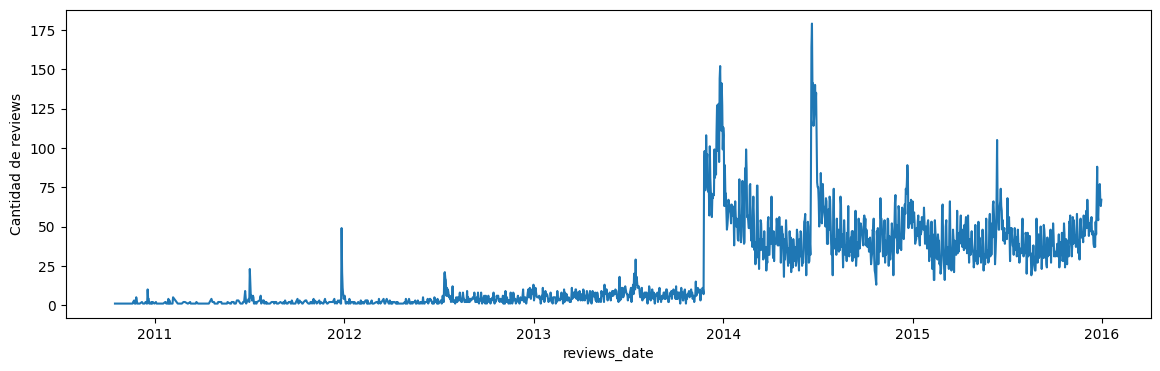

In [14]:
# Gráfico de distribución de la cantidad de reviews por día, sin contar los reviews que no tenían la fecha.

# Se hace un dataframe auxiliar para analizar solo las fechas (hay campos con 'Datos no disponibles')
df = dfreviews[dfreviews["reviews_date"].str.match(r"^\d{4}-\d{2}-\d{2}$")]
# Convierte a formato fecha
df["reviews_date"] = pd.to_datetime(df["reviews_date"])
# Calcula la cantidad de review por fecha
df_counts = df.groupby("reviews_date").count()

# Grafica
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_counts, x="reviews_date", y="reviews_recommend")
plt.ylabel('Cantidad de reviews')
plt.show()

In [15]:
df_counts.sort_values(by='reviews_recommend', ascending=False)

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,sentiment_analysis,anio_lanzamiento
reviews_date,,,,,,,
2014-06-21,179,179,179,179,179,179,179
2014-06-20,164,164,164,164,164,164,164
2013-12-26,152,152,152,152,152,152,152
2013-12-25,144,144,144,144,144,144,144
2014-06-23,141,141,141,141,141,141,141
...,...,...,...,...,...,...,...
2011-10-24,1,1,1,1,1,1,1
2012-08-02,1,1,1,1,1,1,1
2011-10-13,1,1,1,1,1,1,1


In [17]:
print('dias de cantidad pico de reviews:')
df_counts.sort_values(by='reviews_recommend', ascending=False)['reviews_recommend'][:5]

# Se observa que hasta cerca del 2014 la cantidad de reviews por día es bajo, con algunos picos puntuales y luego aumenta considerablemente la cantidad de comentarios con un pico máximo el 21-06-2014 con 218 comentarios en un solo día.

dias de cantidad pico de reviews:


reviews_date
2014-06-21    179
2014-06-20    164
2013-12-26    152
2013-12-25    144
2014-06-23    141
Name: reviews_recommend, dtype: int64

In [18]:
# EDA DE STEAM_GAMES

rutagames = "C:\\Users\\cquir\\OneDrive\\Escritorio\\Data Science SH\\Proyecto Individual 1\\bases de datos\\dfgames_unido.csv"
dfgames = pd.read_csv(rutagames)
dfgames

,genres,price,early_access,id,anio_lanzamiento,publisher,app_name,title,developer
0,Action,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
1,Casual,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
2,Indie,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
3,Simulation,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
4,Strategy,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
...,...,...,...,...,...,...,...,...,...
71546,Indie,1.99,False,610660,2018,Laush Studio,Russian Roads,Russian Roads,Laush Dmitriy Sergeevich
71547,Racing,1.99,False,610660,2018,Laush Studio,Russian Roads,Russian Roads,Laush Dmitriy Sergeevich
71548,Simulation,1.99,False,610660,2018,Laush Studio,Russian Roads,Russian Roads,Laush Dmitriy Sergeevich
71549,Casual,4.99,False,658870,2017,SIXNAILS,EXIT 2 - Directions,EXIT 2 - Directions,"xropi,stev3ns"


In [20]:
# Calculamos la cantidad de registros
print(f'Cantidad de registros: {dfgames.shape[0]}')
verificar_tipo_dato(dfgames)

# Estos datos contienen la información relacionada a cada juego como el precio, el año de lanzamiento, género, entre otros. Se debe considerar la repetición de información porque a un juego se le puede asociar varios generos.

Cantidad de registros: 71551


,nombre_campo,tipo_dato,no_nulos_%,nulos_%,nulos
0,genres,[<class 'str'>],100.00,0.00,0
1,price,[<class 'float'>],100.00,0.00,0
2,early_access,[<class 'bool'>],100.00,0.00,0
3,id,[<class 'int'>],100.00,0.00,0
4,anio_lanzamiento,[<class 'str'>],100.00,0.00,0
5,publisher,"[<class 'str'>, <class 'float'>]",99.93,0.07,47
6,app_name,[<class 'str'>],100.00,0.00,0
7,title,[<class 'str'>],100.00,0.00,0
8,developer,[<class 'str'>],100.00,0.00,0


In [23]:
# Columnas 'id', 'app_name' y 'title'

# Con el 'id' podemos calcular la cantidad de juegos, mientras que app_name y title no tienen mayor información que analizar por el momento

total_juegos = len(dfgames['id'].unique())
print(f"Total de juegos registrados: {total_juegos}")

Total de juegos registrados: 28850


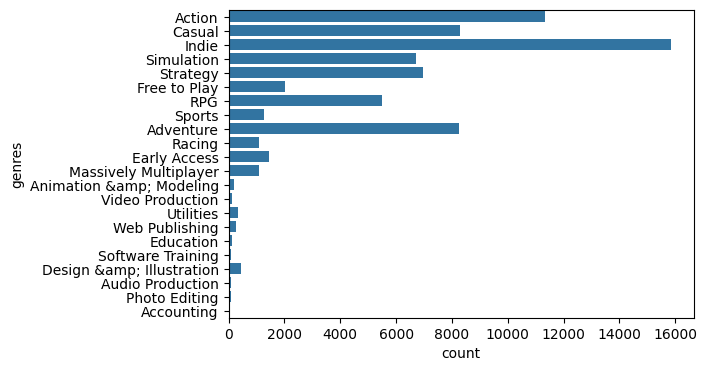

In [24]:
# Columna 'genres'
plt.figure(figsize=(6, 4))
sns.countplot(data=dfgames, y='genres', orient='h')
plt.show()

In [25]:
resumen_cant_porcentaje(dfgames, 'genres')    # Mencionar que un juego puede tener mas de un género asociado

,Cantidad:,Porcentaje:
genres,,
Indie,15858,22.16
Action,11319,15.82
Casual,8282,11.57
Adventure,8242,11.52
Strategy,6957,9.72
Simulation,6699,9.36
RPG,5479,7.66
Free to Play,2031,2.84
Early Access,1462,2.04


In [26]:
# Columna 'release_anio'
resumen_cant_porcentaje(dfgames, 'anio_lanzamiento')[:10]

,Cantidad:,Porcentaje:
anio_lanzamiento,,
2017,24967,34.89
2016,17667,24.69
2015,12256,17.13
2014,6341,8.86
2013,3016,4.22
2012,2106,2.94
2011,986,1.38
Dato no disponible,850,1.19
2010,653,0.91


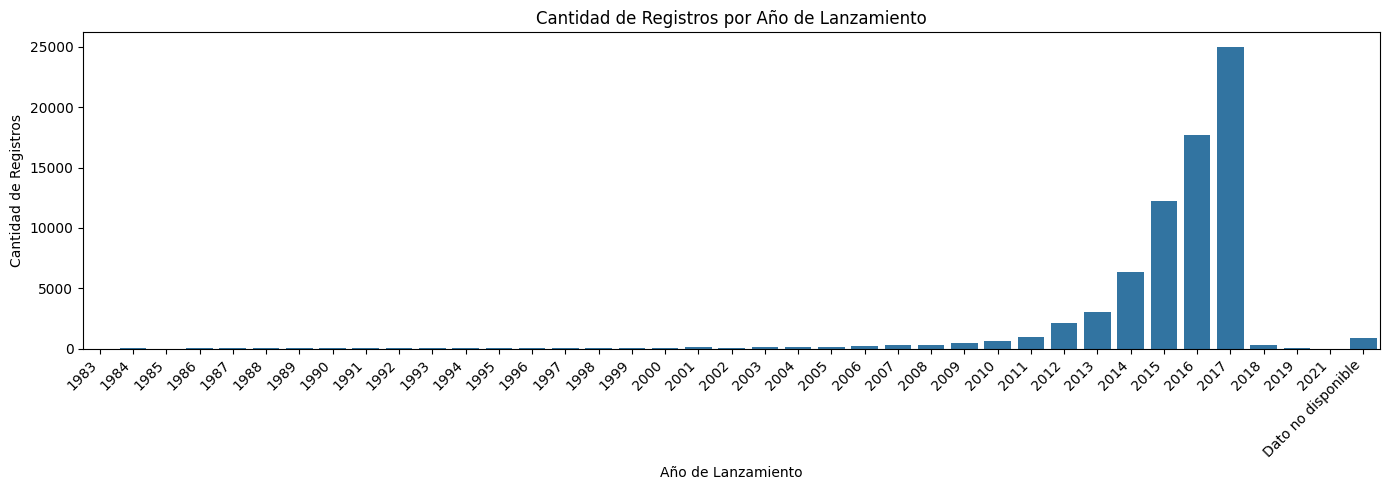

In [28]:
# Cuenta la frecuencia de cada año
conteo_anios = dfgames['anio_lanzamiento'].value_counts()

# Gráfico ordenado y 'Datos no disponibles' quedan al final
conteo_anios = conteo_anios.reindex(['Dato no disponible'] + list(conteo_anios.index))

# Ordenar valores por año
conteo_anios = conteo_anios.sort_index()

# Creando el gráfico
plt.figure(figsize=(14, 5))
sns.barplot(x=conteo_anios.index, y=conteo_anios.values)
plt.xlabel('Año de Lanzamiento') ; plt.ylabel('Cantidad de Registros') ; plt.title('Cantidad de Registros por Año de Lanzamiento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

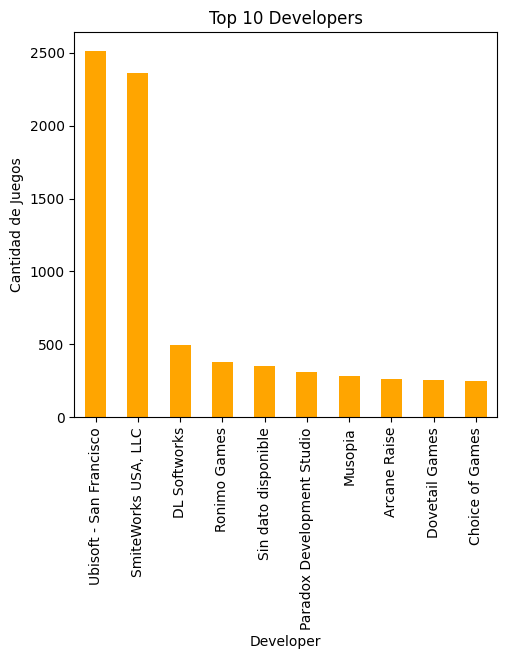

In [33]:
# Columna 'developer'

# Contar la cantidad de juegos por developer
conteo_developer = dfgames['developer'].value_counts()

# Crear una figura con dos subplots uno al lado del otro
plt.figure(figsize=(12, 5))

# Subplot para los developers
plt.subplot(1, 2, 2)
conteo_developer[:10].plot(kind='bar', color='orange')
plt.xlabel('Developer') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 10 Developers')

plt.show()

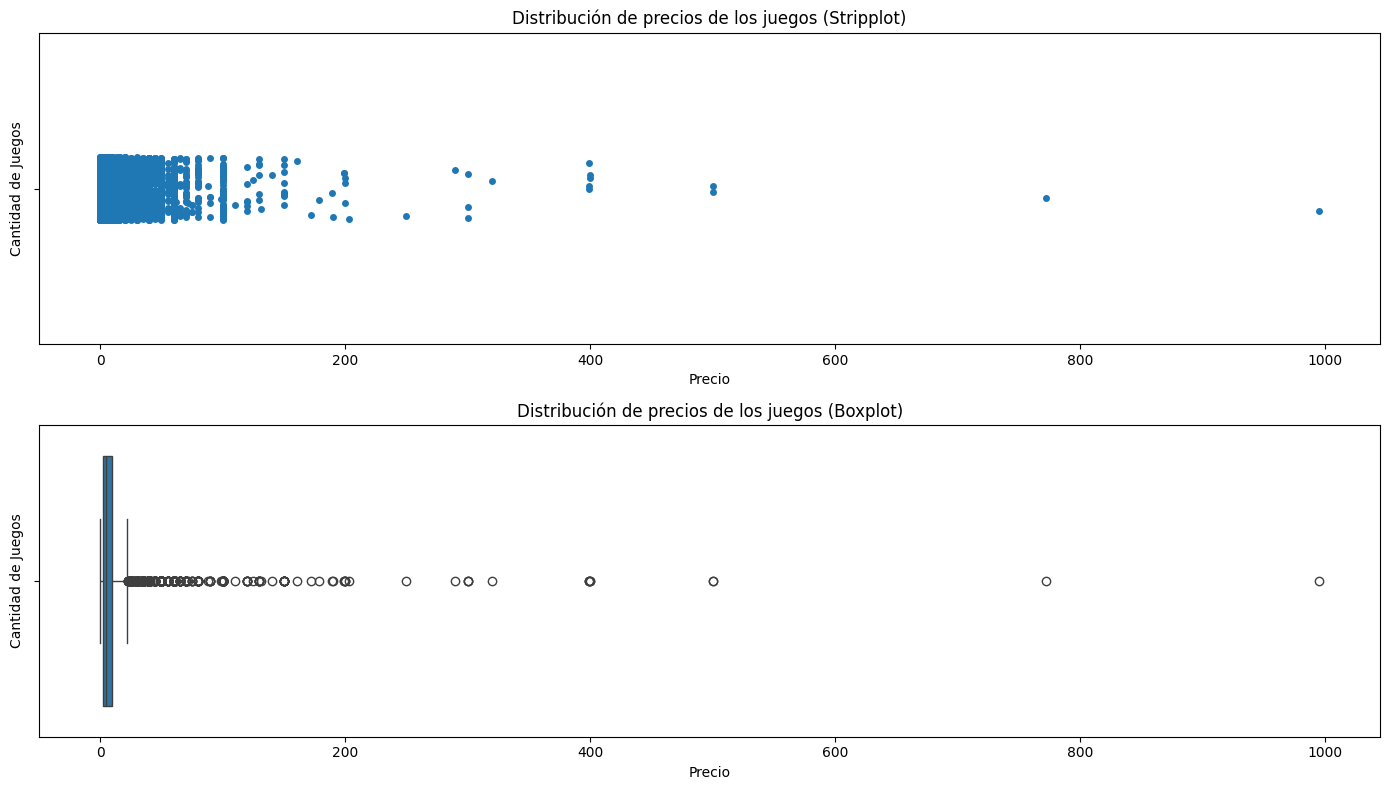

In [36]:
# Columna 'price' 

# Obtiene los precios para cada juego y hace un dataframe
precios_unicos = dfgames.groupby('id')['price'].unique().reset_index().explode('price')       
df_precio_unicos = precios_unicos['price']

# Crear figura y subplots
fig = plt.figure(figsize=(14, 8))

# Subplot 1: Stripplot
ax1 = fig.add_subplot(211)
sns.stripplot(data=precios_unicos, x='price', ax=ax1)
ax1.set_xlabel('Precio')
ax1.set_ylabel('Cantidad de Juegos')
ax1.set_title('Distribución de precios de los juegos (Stripplot)')

# Subplot 2: Boxplot
ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=precios_unicos, x='price', ax=ax2)
ax2.set_xlabel('Precio')
ax2.set_ylabel('Cantidad de Juegos')
ax2.set_title('Distribución de precios de los juegos (Boxplot)')

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [39]:
# De los datos se pueden calcular algunas estadisticas
estadisticas = df_precio_unicos.astype(float).describe()

print(f"la mediana(precio medio) de los datos es de {estadisticas[5]}")
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {estadisticas[6]}')
bigote_max(pd.DataFrame(df_precio_unicos.astype(float))['price'])

# Se Observan 1746 valores podrían ser atípicos, con precios superiores a los 22 dolares, y aquellos de mas de 250 dolares pueden considerarse como erróneos

la mediana(precio medio) de los datos es de 4.99
El precio promedio (mean) de los juegos es de: 8.62
El 75% de los juegos tienen un precio menor de: 9.99
El bigote superior de la variable price se ubica en: 21.99
Hay 1746 valores atípicos en la variable price


In [40]:
# EDA DE USER_ITEMS

rutaitems = "C:\\Users\\cquir\\OneDrive\\Escritorio\\Data Science SH\\Proyecto Individual 1\\bases de datos\\dfitems_unido.csv"
dfitems = pd.read_csv(rutaitems)
dfitems

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
...,...,...,...,...,...,...,...
5094100,346330,BrainBread 2,0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5094101,373330,All Is Dust,0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5094102,388490,One Way To Die: Steam Edition,3,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5094103,521570,You Have 10 Seconds 2,4,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...


In [41]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {dfitems.shape[0]}')

verificar_tipo_dato(dfitems)

La cantidad de registros que hay son: 5094105


,nombre_campo,tipo_dato,no_nulos_%,nulos_%,nulos
0,item_id,[<class 'int'>],100.0,0.0,0
1,item_name,[<class 'str'>],100.0,0.0,0
2,playtime_forever,[<class 'int'>],100.0,0.0,0
3,steam_id,[<class 'int'>],100.0,0.0,0
4,items_count,[<class 'int'>],100.0,0.0,0
5,user_id,[<class 'str'>],100.0,0.0,0
6,user_url,[<class 'str'>],100.0,0.0,0


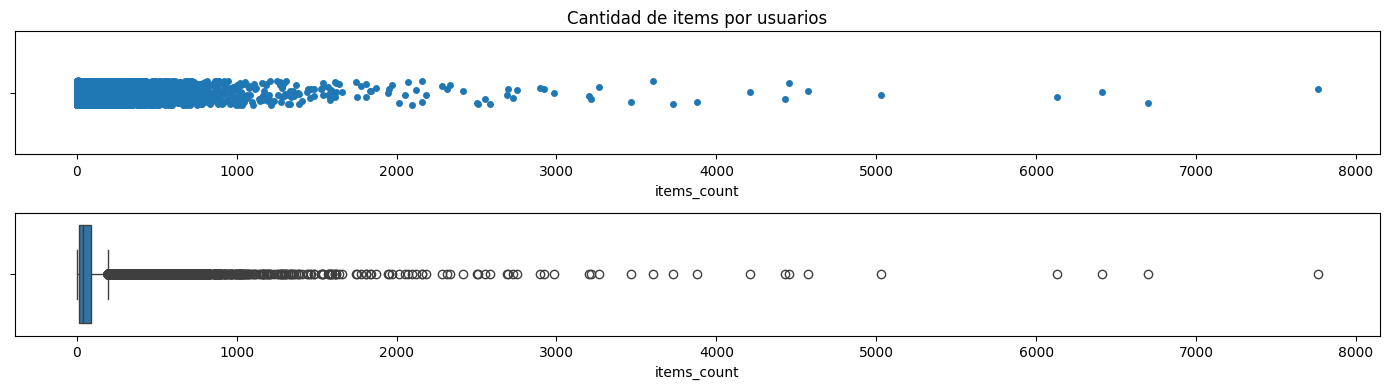

In [42]:
# Agrupa por usuario la cantidad de items, lo conviente en data frame y los ordena de mayor a menor
items_count_user = dfitems.groupby('user_id')['items_count'].unique().explode()

items_count_user = pd.DataFrame(items_count_user)

items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1)
ax1.set_xlabel('items_count') ; ax1.set_title('Cantidad de items por usuarios')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2)
ax2.set_xlabel('items_count')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [43]:
estadisticas2 = items_count_user['items_count'].astype(float).describe()
print(f'El precio medio (mediana) de los juegos es de: {round(estadisticas2[5],2)}')
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas2[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {round(estadisticas2[6],2)}')
bigote_max(items_count_user.astype(float)['items_count'])

El precio medio (mediana) de los juegos es de: 40.0
El precio promedio (mean) de los juegos es de: 71.84
El 75% de los juegos tienen un precio menor de: 87.0
El bigote superior de la variable items_count se ubica en: 196.5
Hay 4957 valores atípicos en la variable items_count


In [46]:
# ELECCIÓN DE LAS VARIABLES PARA EL MODELO ML

# Para el modelo de recomndación se busca como resultado la recomendación un una lista de 5 juegos a partir de indicar el nombre de un juego, basado en un puntaje que se debe decidir cómo crearlo. Para ello, se revisan los dataframe df_reviews y df_items analizados anteriormente.

df_reviews = pd.read_csv("C:\\Users\\cquir\\OneDrive\\Escritorio\\Data Science SH\\Proyecto Individual 1\\bases de datos\\dfreviews_unido.csv", encoding='utf-8')
df_items = pd.read_csv("C:\\Users\\cquir\\OneDrive\\Escritorio\\Data Science SH\\Proyecto Individual 1\\bases de datos\\dfitems_unido.csv", encoding='utf-8')

In [47]:
df_reviews.head(2)

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis,anio_lanzamiento
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,1,2009
1,evcentric,http://steamcommunity.com/id/evcentric,248820,No ratings yet,True,Formato inválido,2,2013


In [48]:
df_items.head(2)

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


In [49]:
# Con los datos, se decide crear un puntaje (rating) para los juegos a partir de considerar el análisis de sentimiento de las reviews para cada juego y las recomendaciones del usuario para ese juego. Recordar que el análisis de sentimiento esta calificado como 0 (sentimiento negativo), 1 (sentimiento neutral) y 2 (sentimiento positivo) y las recomendaciones al juego son True (cuando lo recomienda) y False (cuando no recomienda el juego). Con esta información se busca hacer un puntaje del 1 al 5, siendo el 1 un juego no recomendado que cuentan con reviews con sentimientos negativos y 5 un juego recomendado y con reviews positivos. Se considera esta escala en función de la combinación de las dos variables de esta manera:

# 1 si el análisis de sentimiento es negativo ya sea que este recomendado o no (True o False)
# 2 si el análisis de sentimiento es neutral y no es recomendado (False)
# 3 si el análisis de sentimiento es neutral pero es recomendado (True)
# # 4 si el análisis de sentimiento es positivo y no es recomendado (False)
# 5 si el análisis de sentimiento es positivo y es recomendado (True)

# Con esto, se arma la siguiente función:

def calcula_rating(row):
    '''
    Calcula una calificación basada en el análisis de sentimientos y la recomendación de review de juegos realizado por los usuarios.

    Parámetros:
    row (dict): Un diccionario que contiene las siguientes claves:
        - "sentiment_analysis" (int): La puntuación del análisis de sentimientos (0, 1 o 2).
        - "reviews_recommend" (bool): Indica si las reseñas recomiendan.

    Devuelve:
        int o None: La calificación calculada como un número entero entre 1 y 5, o None si las entradas son inválidas '''
    
    if row['sentiment_analysis'] == 0 and not row['reviews_recommend']:
        return 1
    elif row['sentiment_analysis'] == 0 and row['reviews_recommend']:
        return 1
    elif row['sentiment_analysis'] == 1 and not row['reviews_recommend']:
        return 2
    elif row['sentiment_analysis'] == 1 and row['reviews_recommend']:
        return 3
    elif row['sentiment_analysis'] == 2 and not row['reviews_recommend']:
        return 4
    elif row['sentiment_analysis'] == 2 and row['reviews_recommend']:
        return 5
    else:
        return None

In [52]:
# Se aplica esta función en una nueva columna sobre el dataframe df_reviews
df_reviews['rating'] = df_reviews.apply(calcula_rating, axis=1)
df_reviews.head()

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis,anio_lanzamiento,rating
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,1,2009,3
1,evcentric,http://steamcommunity.com/id/evcentric,248820,No ratings yet,True,Formato inválido,2,2013,5
2,doctr,http://steamcommunity.com/id/doctr,250320,2 of 2 people (100%) found this review helpful,True,2013-10-14,2,2013,5
3,maplemage,http://steamcommunity.com/id/maplemage,211420,35 of 43 people (81%) found this review helpful,True,2014-04-15,1,2012,3
4,Wackky,http://steamcommunity.com/id/Wackky,249130,7 of 8 people (88%) found this review helpful,True,2014-05-05,0,2013,1


In [63]:
# Se crea un nuevo dataframe con 'user_id', 'reviews_item_id' y 'rating'

df1 = df_reviews[['user_id', 'reviews_item_id', 'rating']]
df1.head()

,user_id,reviews_item_id,rating
0,76561197970982479,1250,3
1,evcentric,248820,5
2,doctr,250320,5
3,maplemage,211420,3
4,Wackky,249130,1


In [62]:
# Se crea otro dataframe que contiene 'item_id' y los nombres de los juegos.
df2 = df_items[['item_id', 'item_name']]
# se borran los duplicados
df2 = df2.drop_duplicates()
# cantidad de juegos
print(f"hay {len(df2)} juegos")
df2.head()

hay 10978 juegos


,item_id,item_name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force


In [56]:
#Agregamos los nombres de los juegos al primer df.
df = df1.merge(df2, left_on='reviews_item_id', right_on='item_id', how='left')
df

,user_id,reviews_item_id,rating,item_id,item_name
0,76561197970982479,1250,3,1250.0,Killing Floor
1,evcentric,248820,5,248820.0,Risk of Rain
2,doctr,250320,5,250320.0,The Wolf Among Us
3,maplemage,211420,3,211420.0,Dark Souls: Prepare to Die Edition
4,Wackky,249130,1,249130.0,LEGO® MARVEL Super Heroes
...,...,...,...,...,...
48797,kushikushigani,332310,3,332310.0,LEGO® Worlds
48798,How51,440,3,NaN,NaN
48799,76561198111410893,304930,3,304930.0,Unturned
48800,zaza147,265630,5,265630.0,Fistful of Frags


In [57]:
# Se pueden observar algunos juegos a los cuales los usuarios les hicieron comentarios, pero que no estan en el dataframe df_reviews. Se verifican los tipos de datos y la cantidad de nulos y luego se revisan las filas con nulos.
verificar_tipo_dato(df)

,nombre_campo,tipo_dato,no_nulos_%,nulos_%,nulos
0,user_id,[<class 'str'>],100.00,0.00,0
1,reviews_item_id,[<class 'int'>],100.00,0.00,0
2,rating,[<class 'int'>],100.00,0.00,0
3,item_id,[<class 'float'>],90.58,9.42,4597
4,item_name,"[<class 'str'>, <class 'float'>]",90.58,9.42,4597


In [58]:
# se revisan los reviews sin nombres de juegos en `df_items`
sin_juegos = df[df.isnull().any(axis=1)]
# Se calculan la cantidad de juegos en esta situación
print(f"hay un total de {len(sin_juegos['reviews_item_id'].unique())} juegos con reviews pero que no estan en df_reviews")
sin_juegos

hay un total de 255 juegos con reviews pero que no estan en df_reviews


,user_id,reviews_item_id,rating,item_id,item_name
8,76561198077246154,440,3,NaN,NaN
16,devvonst,440,5,NaN,NaN
29,boydeer,440,3,NaN,NaN
34,jarrodtrim,440,5,NaN,NaN
36,76561198067936203,440,3,NaN,NaN
...,...,...,...,...,...
48763,JacTehSharp,440,3,NaN,NaN
48765,ViniReaper,440,5,NaN,NaN
48785,BlinkV1,440,3,NaN,NaN
48790,76561198095035915,440,1,NaN,NaN


In [59]:
# Se borran los nulos
df = df.dropna(subset=['item_id'])
# Se cuentan los registros que quedan
print(f'quedan {df.shape[0]} registros')
# Se verifican los tipo de dato y nulos
verificar_tipo_dato(df)

quedan 44205 registros


,nombre_campo,tipo_dato,no_nulos_%,nulos_%,nulos
0,user_id,[<class 'str'>],100.0,0.0,0
1,reviews_item_id,[<class 'int'>],100.0,0.0,0
2,rating,[<class 'int'>],100.0,0.0,0
3,item_id,[<class 'float'>],100.0,0.0,0
4,item_name,[<class 'str'>],100.0,0.0,0


In [61]:
# Se convierte en entero la columna 'item_id' y se crea un último dataframe con las columnas necesarias para los modelos de recomendación.
df = df[['user_id', 'item_name', 'rating']]
df.head()

,user_id,item_name,rating
0,76561197970982479,Killing Floor,3
1,evcentric,Risk of Rain,5
2,doctr,The Wolf Among Us,5
3,maplemage,Dark Souls: Prepare to Die Edition,3
4,Wackky,LEGO® MARVEL Super Heroes,1


In [64]:
# Cantidades de review por rating
resumen_cant_porcentaje(df, 'rating')

,Cantidad:,Porcentaje:
rating,,
3,24158,54.65
5,12458,28.18
1,3907,8.84
2,3252,7.36
4,430,0.97


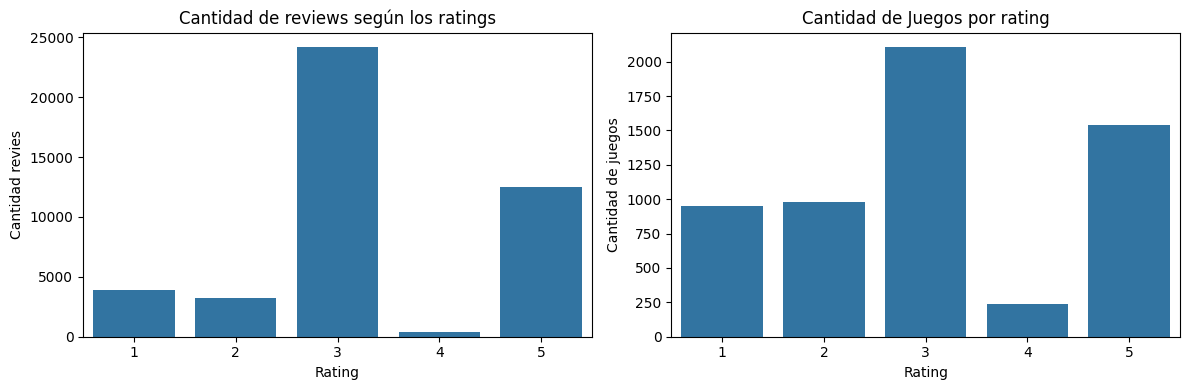

In [69]:
# En el siguiente gráfico se pueden ver la cantidad de reviews distribuidos por el puntaje adoptado.

# Agrupa las calificaciones por rating
ratings_count = df['rating'].value_counts().reset_index()
ratings_count
ratings_count.columns = ['rating', 'count']

# Agrupa los juegos únicos por rating
juegos_unicos_por_rating = df.groupby('rating')['item_name'].nunique().reset_index()

# Crea una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Primer subplot
sns.barplot(data=ratings_count, x='rating', y='count', ax=axes[0])
axes[0].set_title('Cantidad de reviews según los ratings') ; axes[0].set_xlabel('Rating') ; axes[0].set_ylabel('Cantidad revies')

# Segundo subplot
sns.barplot(data=juegos_unicos_por_rating, x='rating', y='item_name', ax=axes[1])
axes[1].set_title('Cantidad de Juegos por rating') ; axes[1].set_xlabel('Rating') ; axes[1].set_ylabel('Cantidad de juegos')

# Ajusta y muestra los graficos
plt.tight_layout()
plt.show()

In [70]:
# Cantidades de juegos por rating
juegos_unicos_por_rating

,rating,item_name
0,1,954
1,2,980
2,3,2105
3,4,240
4,5,1539


In [71]:
# Cantidades de juegos por rating
juegos_unicos_por_rating

,rating,item_name
0,1,954
1,2,980
2,3,2105
3,4,240
4,5,1539


In [72]:
# Se puede ver en la gráfica de la derecha que la mayoría de las reviews tienen un 'rating' de 3, correspondiente a sentimientos neutrales pero que recomiendan el juego, siendo el 54% de reviews en esta categoría y 12458 reviews con sentimientos positivos y que recomiendan los juegos que comentan.

# Finalmente, se guarda el dataframe a utilizar en el modelo de recomnedación.
df.to_csv("C:\\Users\\cquir\\OneDrive\\Escritorio\\Data Science SH\\Proyecto Individual 1\\bases de datos\\df_recomendacion", index=False, encoding='utf-8')